### D208 Performance Assessment Task 2
##### NBM3 Task2 Logistic Regression Modeling
Predictive Modeling - D208
PRFA - NBM3

### Competencies

##### 4030.5.2 : Multiple Regression
The graduate employs multiple regression algorithms with categorical and numerical predictors in describing phenomena.

##### 4030.5.3 : Regression Implications
The graduate makes assertions based on regression modeling.

#### Imports

 * Standard Imports
   * [Pandas](https://pandas.pydata.org/)
   * [NumPy](https://numpy.org/doc/stable/)
 * Visualizations
   * [matplotlib](https://matplotlib.org/stable/index.html)
   * [Seaborn](https://seaborn.pydata.org/)
 * Statistical
   * [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
   * [MSE (Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
   * [Variance Inflation Factor (VIF)](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)
   * [Logit](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html)
   * [Selection: Train Test Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
   * [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Data Preparation C1
## Loading Medical Dataset, Renaming, and Category Type Changes
Loading `medical_clean.csv`
The data for this performance assessments comes pre-cleaned similar to the output result from D207.

  * Check the datatypes
  * Check for null, na, and empty values
  * Rename Items1-8
  * Update chr, str datatypes to 'Category'
  * Removing categorical variables with high cardinality. They can potentially lead to over-fitting models.

In [2]:
original_medical = medical_clean_data = pd.read_csv('./medical_clean.csv')
#del medical_clean_data[medical_clean_data.columns[0]]

any_missing_values = medical_clean_data.isna().values.any()
if not any_missing_values:
    print('Medical data does NOT contain any missing values\n')
else:
    print('Medical data CONTAINS missing values.\n')

column_renames = {
    'Item1': 'Timely_Admission'
    ,'Item2': 'Timely_Treatment'
    ,'Item3': 'Timely_Visits'
    ,'Item4': 'Reliability'
    ,'Item5': 'Options'
    ,'Item6': 'Hours_Of_Treatment'
    ,'Item7': 'Courteous_Staff'
    ,'Item8': 'Listening' #Evidence of active listening from Doctor
}
medical_clean_data.rename(columns=column_renames, inplace=True)
#medical_clean_data

removal_attributes = ['CaseOrder', 'Customer_id', 'Interaction', 'UID',
                      'Zip', 'Lat', 'Lng', 'City', 'State', 'County',
                      'Area', 'Job', 'Marital', 'Population', 'TimeZone']

medical_clean_data = medical_clean_data.drop(columns=removal_attributes)

category_dtype = 'category'
convert_to_category = {
    'Gender': category_dtype,
    'ReAdmis': category_dtype,
    'Soft_drink': category_dtype,
    'Initial_admin': category_dtype,
    'HighBlood': category_dtype,
    'Stroke': category_dtype,
    'Complication_risk': category_dtype,
    'Overweight': category_dtype,
    'Arthritis': category_dtype,
    'Diabetes': category_dtype,
    'Hyperlipidemia': category_dtype,
    'BackPain': category_dtype,
    'Anxiety': category_dtype,
    'Allergic_rhinitis': category_dtype,
    'Reflux_esophagitis': category_dtype,
    'Asthma': category_dtype,
    'Services': category_dtype,
    'Timely_Admission': category_dtype,
    'Timely_Treatment': category_dtype,
    'Timely_Visits': category_dtype,
    'Reliability': category_dtype,
    'Options': category_dtype,
    'Hours_Of_Treatment': category_dtype,
    'Courteous_Staff': category_dtype,
    'Listening': category_dtype
}

medical_clean_data = medical_clean_data.astype(convert_to_category)

#Logical categorical variables converted to numerical
columns_to_reexpress = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke',
                        'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
                        'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis',
                        'Asthma']
for column in columns_to_reexpress:
    medical_clean_data[column] = medical_clean_data[column].map({'Yes': 1, 'No': 0 }).astype(np.int64)

categorical_medical_data = medical_clean_data[convert_to_category.keys()]
high_cardinalities = categorical_medical_data.nunique() > 3 #(> 3-5 Levels)
high_cardinalities = high_cardinalities[high_cardinalities == True]
high_cardinalities = list(high_cardinalities.index.values)
print('Categoricals with high cardinality to be removed:')
print(high_cardinalities)
print('\n')

medical_clean_data = medical_clean_data.drop(columns=high_cardinalities)

low_cardinalities = [item for item in list(convert_to_category.keys()) if item not in high_cardinalities]
print('Categoricals remaining:')
print(low_cardinalities)
print('\n')

#Re-level ordinal/nominal categoricals
complication_risk_dummies = pd.get_dummies(data=medical_clean_data['Complication_risk'], drop_first=True)

medical_clean_data['complication_risk_medium'] = complication_risk_dummies['Medium']
medical_clean_data['complication_risk_low'] = complication_risk_dummies['Low']

initial_admission_dummies = pd.get_dummies(data=medical_clean_data['Initial_admin'], drop_first=True)

medical_clean_data['initial_admission_emergency'] = initial_admission_dummies['Emergency Admission']
medical_clean_data['initial_admission_observation'] = initial_admission_dummies['Observation Admission']

gender_dummies = pd.get_dummies(data=medical_clean_data['Gender'], drop_first=True)

medical_clean_data['gender_male'] = gender_dummies['Male']
medical_clean_data['gender_non_binary'] = gender_dummies['Nonbinary']

regression_variables = ['Children', 'Age', 'VitD_levels', 'HighBlood', 'Overweight', 'Arthritis', 'Diabetes', 'BackPain', 'Asthma', 'Initial_days', 'ReAdmis', 'complication_risk_medium', 'complication_risk_low', 'initial_admission_emergency', 'initial_admission_observation', 'gender_male','gender_non_binary']

prepared_medical_data = medical_clean_data[regression_variables]

Medical data does NOT contain any missing values

Categoricals with high cardinality to be removed:
['Services', 'Timely_Admission', 'Timely_Treatment', 'Timely_Visits', 'Reliability', 'Options', 'Hours_Of_Treatment', 'Courteous_Staff', 'Listening']


Categoricals remaining:
['Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']


In [3]:
## Data Preparation C2

#### Summary Statistics

In [4]:
prepared_medical_data.describe(include='all')

,Children,Age,VitD_levels,HighBlood,Overweight,Arthritis,Diabetes,BackPain,Asthma,Initial_days,ReAdmis,complication_risk_medium,complication_risk_low,initial_admission_emergency,initial_admission_observation,gender_male,gender_non_binary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.097200,53.511700,17.964262,0.409000,0.709400,0.357400,0.27380,0.411400,0.28930,34.455299,0.366900,0.451700,0.212500,0.506000,0.243600,0.476800,0.021400
std,2.163659,20.638538,2.017231,0.491674,0.454062,0.479258,0.44593,0.492112,0.45346,26.309341,0.481983,0.497687,0.409097,0.499989,0.429276,0.499486,0.144721
min,0.000000,18.000000,9.806483,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,1.001981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,16.626439,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,7.896215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,53.000000,17.951122,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,35.836244,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,71.000000,19.347963,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,61.161020,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,10.000000,89.000000,26.394449,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,71.981490,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Preparation C3

#### Generate Univariate and Bivariate Visualizations of distributions

Univariate Numerical Variables


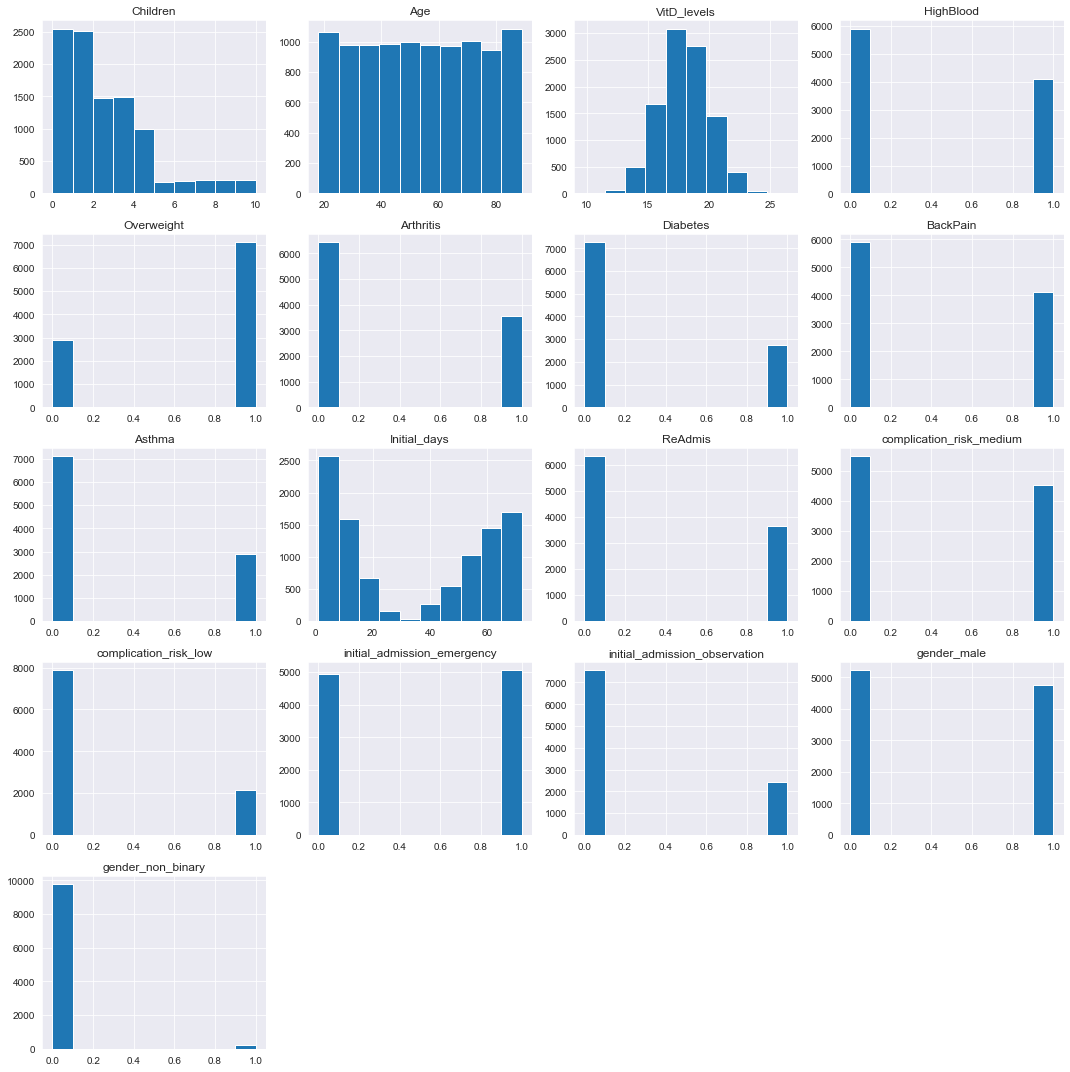

In [5]:
print('Univariate Numerical Variables')

prepared_medical_data.hist(figsize=(15, 15))
plt.savefig('univariate-histograms.jpg')
plt.tight_layout()

Bivariate Numerical Variables
['Children', 'Age', 'VitD_levels', 'HighBlood', 'Overweight', 'Arthritis', 'Diabetes', 'BackPain', 'Asthma', 'Initial_days', 'ReAdmis', 'complication_risk_medium', 'complication_risk_low', 'initial_admission_emergency', 'initial_admission_observation', 'gender_male', 'gender_non_binary']


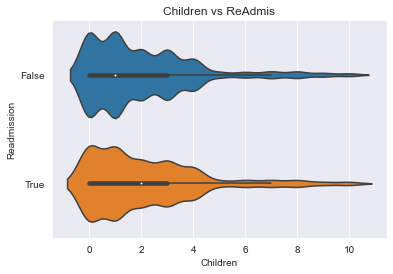

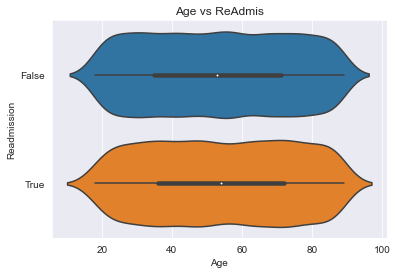

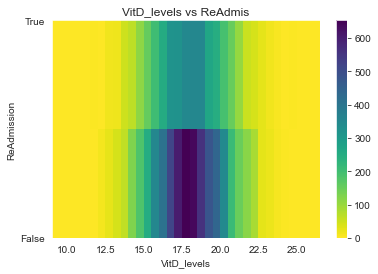

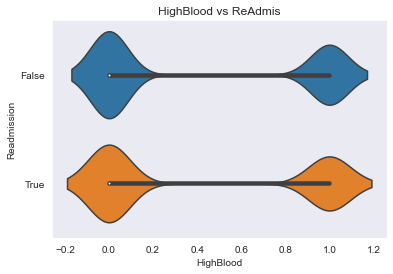

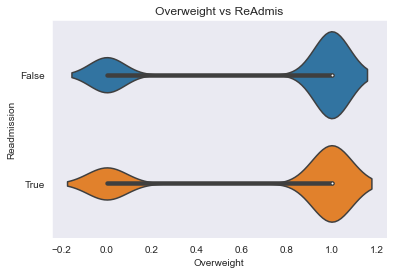

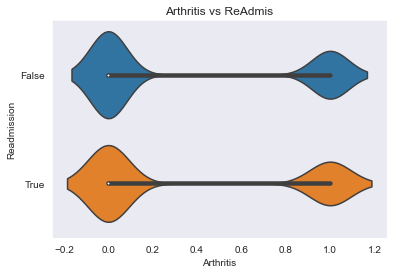

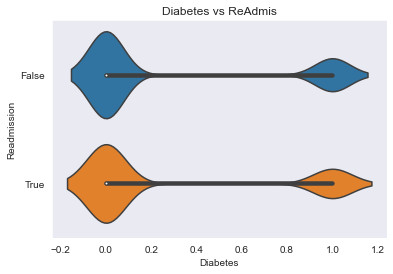

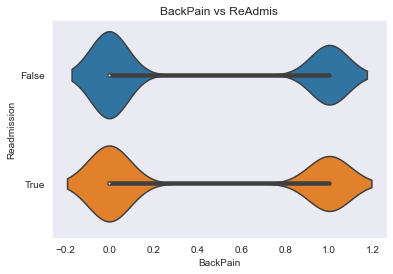

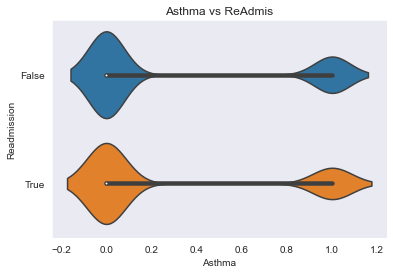

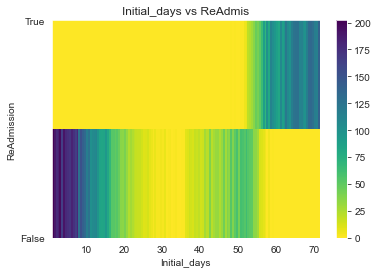

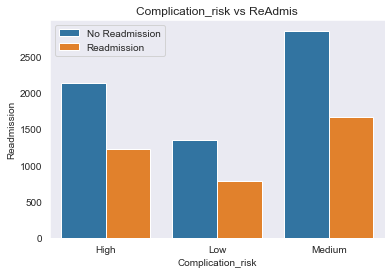

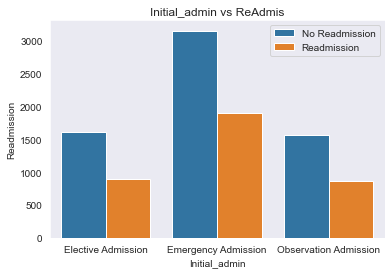

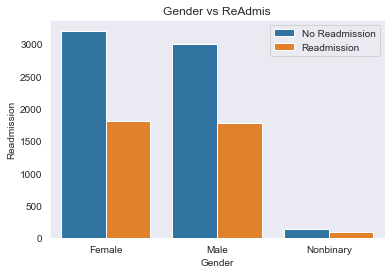

In [6]:
print('Bivariate Numerical Variables')

print(regression_variables)

def bivariate_count_plot_vs_readmission(data: pd.DataFrame, x: str) -> None:
    plt.title(f'{x} vs ReAdmis')
    sns.countplot(data=data, x=x, hue='ReAdmis')
    plt.legend(['No Readmission', 'Readmission'])
    plt.xlabel(x)
    plt.ylabel('Readmission')
    plt.show()

def bivariate_violin_plot_vs_readmission(data: pd.DataFrame, x: str) -> None:
    plt.title(f'{x} vs ReAdmis')
    sns.violinplot(data=data, x=x, y='ReAdmis', orient='h')
    plt.xlabel(f'{x}')
    plt.ylabel('Readmission')
    plt.yticks([0,1], ['False', 'True'])
    plt.show()

def bivariate_2d_hist_vs_readmission(data: pd.DataFrame, x: str, bin_increment: float = 1) -> None:
    plt.rcParams['axes.grid'] = False #stops the deprecation warning
    start = np.floor(prepared_medical_data[x].min())
    end = np.ceil(prepared_medical_data[x].max())
    x_bins = np.arange(start, end, bin_increment)

    y_logical_bins = np.arange(0, 1.01, .5)

    plt.title(f'{x} vs ReAdmis')
    plt.hist2d(data=data, x=x, y='ReAdmis', bins=[x_bins, y_logical_bins], cmap='viridis_r')
    plt.grid(False)
    plt.colorbar()
    plt.xlabel(x)
    plt.ylabel('ReAdmission')
    plt.yticks([0,1], ['False', 'True'])
    plt.show()


bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Children')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Age')
bivariate_2d_hist_vs_readmission(data=prepared_medical_data, x='VitD_levels', bin_increment=.5)
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='HighBlood')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Overweight')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Arthritis')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Diabetes')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='BackPain')
bivariate_violin_plot_vs_readmission(data=prepared_medical_data, x='Asthma')
bivariate_2d_hist_vs_readmission(data=prepared_medical_data, x='Initial_days', bin_increment=.5)
bivariate_count_plot_vs_readmission(data=medical_clean_data, x='Complication_risk')
bivariate_count_plot_vs_readmission(data=medical_clean_data, x='Initial_admin')
bivariate_count_plot_vs_readmission(data=medical_clean_data, x='Gender')






## Prepared DataSet

In [7]:
prepared_medical_data.to_csv('./initial-logistic-medical-model-dataset.csv')

## D1: Initial Logistic Regression Model

In [8]:
dependent = prepared_medical_data['ReAdmis']

#In logistic regression, adding a constant term to the predictor variables is important for estimating the intercept term in the logistic regression equation.
initial_explanatory_variables = prepared_medical_data.drop('ReAdmis', axis=1).assign(const=1)

initial_logic_model: Logit = Logit(dependent, initial_explanatory_variables)
initial_logit_result = initial_logic_model.fit()
print(initial_logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.039057
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9983
Method:                           MLE   Df Model:                           16
Date:                Mon, 17 Apr 2023   Pseudo R-squ.:                  0.9406
Time:                        21:58:00   Log-Likelihood:                -390.57
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Children                          0.0620      0.042      1.483      0

## D2: Statistically based feature selection procedure or a model evaluation metric

In [9]:
'''
Variance Inflation Factor (VIF):

VIF Values:
1:     No Collinearity
>1:    Increasing levels of collinearity
>5-10: Severe Collinearity removal recommended.
'''
def check_vif(data: pd.DataFrame) -> pd.DataFrame:
    data = {
        'Feature': data.columns,
        'VIF': [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    }
    results = pd.DataFrame(data)
    return results

vif_results = check_vif(prepared_medical_data.drop('ReAdmis', axis=1))
print(vif_results)
#VitD_levels is well over a value of 10 coming in at 17+

#remove any items with a VIF score of 10 or greater.
vif_to_remove = list(vif_results[vif_results['VIF'] >= 10]['Feature'])
prepared_medical_data.drop(columns=vif_to_remove, inplace=True)



                          Feature        VIF
0                        Children   1.929125
1                             Age   7.253514
2                     VitD_levels  17.133269
3                       HighBlood   1.686521
4                      Overweight   3.372165
5                       Arthritis   1.552106
6                        Diabetes   1.370021
7                        BackPain   1.691967
8                          Asthma   1.404884
9                    Initial_days   2.676873
10       complication_risk_medium   2.316105
11          complication_risk_low   1.617007
12    initial_admission_emergency   2.959754
13  initial_admission_observation   1.937648
14                    gender_male   1.926632
15              gender_non_binary   1.043265


C:\Temp\ipykernel_33240\3075938696.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prepared_medical_data.drop(columns=vif_to_remove, inplace=True)


In [10]:
'''
Backwards Elimination Process:

The backward elimination process starts by fitting a logistic regression model with all the predictors, and then evaluating the significance of each predictor using its p-value.
The predictor with the highest p-value is removed from the model, and the new model is fitted with the remaining predictors.
The process is repeated until no more predictors can be removed without significantly affecting the model's performance.

Goal: Remove the highest p-value that remains above 0.10
'''

def backwards_elimination(title: str, dependent: pd.Series, explanatory_variables: pd.DataFrame) -> (bool, pd.DataFrame):
    print(title, '\n')

    removal_limit = .10
    more_eliminations = False
    #print(f'Remove the highest p-value that remains above {removal_limit:.2f}')
    logit_model: Logit = Logit(dependent, explanatory_variables)
    model_result = logit_model.fit()

    print(model_result.summary())

    p_values: pd.Series = model_result.pvalues

    filtered_p_values = p_values[p_values > removal_limit].sort_values(ascending=False)
    if len(filtered_p_values) > 0:
        biggest_value_name = filtered_p_values.index[0]
        biggest_value = filtered_p_values[0]
        print('-------------------------------------------------------------------------------------------')
        print(f'\n"{biggest_value_name}" is to be removed with a value of [{biggest_value}]\n')
        print('-------------------------------------------------------------------------------------------')
        print('\n')

        explanatory_variables.drop(biggest_value_name, axis=1, inplace=True)

        more_eliminations = True
        return more_eliminations, explanatory_variables
    else:
        print('\nNo Backwards Eliminations are required.\n')
        return more_eliminations, explanatory_variables

dependent = prepared_medical_data['ReAdmis']
#In logistic regression, adding a constant term to the predictor variables is important for estimating the intercept term in the logistic regression equation.
initial_explanatory_variables = prepared_medical_data.drop('ReAdmis', axis=1).assign(const=1)

elimination_count = 1
continue_running_backwards_elimination = True
while continue_running_backwards_elimination:
    title = f'Backwards Elimination #{elimination_count}: Eliminate highest p-value above 0.10'

    continue_processing, filtered_explanatory_variables = backwards_elimination(title, dependent, initial_explanatory_variables)
    reduced_explanatory_variables = filtered_explanatory_variables
    elimination_count = elimination_count + 1
    continue_running_backwards_elimination = continue_processing

print(f'Remaining explanatory variables are [{reduced_explanatory_variables.columns}]')

Backwards Elimination #1: Eliminate highest p-value above 0.10 

Optimization terminated successfully.
         Current function value: 0.039073
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9984
Method:                           MLE   Df Model:                           15
Date:                Mon, 17 Apr 2023   Pseudo R-squ.:                  0.9406
Time:                        21:58:03   Log-Likelihood:                -390.73
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Chil

## Reduced Model after running VIF and Backwards Elimination Techniques

In [11]:
dependent = prepared_medical_data['ReAdmis']

reduced_logit_model = Logit(dependent, reduced_explanatory_variables)
reduced_logit_result = reduced_logit_model.fit()
print(reduced_logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.039418
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Mon, 17 Apr 2023   Pseudo R-squ.:                  0.9400
Time:                        21:58:04   Log-Likelihood:                -394.18
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Children                          0.0738      0.041      1.790      0

## E:  Analyze the data set using your reduced logistic regression model

In [12]:
'''
This will calculation values needed for Analysing a Logistic Regression Model

This will return the MSE (Mean Squared Error, Confusion Matrix and Accuracy Score based on a Dependent variable and Explanatory Variables
'''
def calculate_evaluation_info(target: pd.Series, explanatory_variables: pd.DataFrame) -> (float, object, float):
    explanatory_train, explanatory_test, dependent_train, dependent_test = train_test_split(explanatory_variables, target, test_size=0.3, random_state=42)

    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(explanatory_train, dependent_train)
    dependent_predictions = logistic_regression.predict(explanatory_test)

    print(f'"ReAdmis" Logistic Regression Predictions with test data. Top 10')
    print(dependent_predictions[:10])

    mse = mean_squared_error(dependent_test, dependent_predictions)
    c_matrix = confusion_matrix(dependent_test, dependent_predictions)
    accuracy_score = logistic_regression.score(explanatory_test, dependent_test)

    return mse, c_matrix, accuracy_score

initial_mse, initial_confusion_matrix, initial_accuracy_score = calculate_evaluation_info(dependent, initial_explanatory_variables)
print(f'Initial Regression Models MSE: [{initial_mse}]\n')
print('Initial Logic Regression Model Confusion Matrix:')
print(initial_confusion_matrix)
print(f'\nAccuracy Score of Initial Logistic Regression test datasets is: {initial_accuracy_score:.2f}\n')

print('\n')

reduced_mse, reduced_confusion_matrix, reduced_accuracy_score = calculate_evaluation_info(dependent, reduced_explanatory_variables)
print(f'Reduced Regression Models MSE: [{reduced_mse}]\n')
print('Reduced Logic Regression Model Confusion Matrix:')
print(reduced_confusion_matrix)
print(f'\nAccuracy Score of Reduced Logistic Regression test datasets is: {reduced_accuracy_score:.2f}\n')

'''
    Odd Ration:
        Compares the odds of an event occurring in one group to the odds of the same event occurring in another group.
        Meanings:
        1  - Event is likely in both groups
        >1 - Event is likely in 1st group
        <1 - Event is likely in 2nd group

    Sigmoid(Logic Function):
        Maps any input value to a value between 0 and 1.

        This f(x) has an S-shaped curve, which allows it to be used to model probability of events occurring.

        Interpretations:
            The probability of the dependent(target) variable takin on the value 1, given the values of
            independent variables.

        Fun Factoid: This f(x) is widely used in neural networks. Output of a neuron is converted to 0 and 1 for
                     probability interpretation.
'''
def calculate_odds_ration_and_sigmoid(coefficient: float) -> (float, float):
    odds_ration = np.exp(coefficient)
    sigmoid = 1 / (1 + np.exp(-coefficient))
    return round(odds_ration, 4), round(sigmoid, 4)

#print(reduced_logit_result.params.index)
print('Initial Model Odds Ration')
for index in initial_logit_result.params.index:
    odds_ratio, predicted_probability = calculate_odds_ration_and_sigmoid(initial_logit_result.params[index])
    print(f'Odd ratio for {index} is {odds_ratio}. The change in odds for Readmission (ReAdmis) is {predicted_probability}.')

print('\n')

print('Reduced Model Odds Ratios')
for index in reduced_logit_result.params.index:
    odds_ratio, predicted_probability = calculate_odds_ration_and_sigmoid(reduced_logit_result.params[index])
    print(f'Odd ratio for {index} is {odds_ratio}. The change in odds for Readmission (ReAdmis) is {predicted_probability}.')


"ReAdmis" Logistic Regression Predictions with test data. Top 10
[0 0 0 0 0 0 0 1 1 0]
Initial Regression Models MSE: [0.017]

Initial Logic Regression Model Confusion Matrix:
[[1912   22]
 [  29 1037]]

Accuracy Score of Initial Logistic Regression test datasets is: 0.98



"ReAdmis" Logistic Regression Predictions with test data. Top 10
[0 0 0 0 0 0 0 1 1 0]
Reduced Regression Models MSE: [0.017]

Reduced Logic Regression Model Confusion Matrix:
[[1912   22]
 [  29 1037]]

Accuracy Score of Reduced Logistic Regression test datasets is: 0.98

Initial Model Odds Ration
Odd ratio for Children is 1.064. The change in odds for Readmission (ReAdmis) is 0.5155.
Odd ratio for Age is 1.0015. The change in odds for Readmission (ReAdmis) is 0.5004.
Odd ratio for VitD_levels is 1.026. The change in odds for Readmission (ReAdmis) is 0.5064.
Odd ratio for HighBlood is 2.109. The change in odds for Readmission (ReAdmis) is 0.6784.
Odd ratio for Overweight is 0.8362. The change in odds for Readmissi